# Tutorial

This tutorial contains several examples with `GaussianRandomFields`. We start by three generic exampls: exponential covariance in one dimension, Matérn covariance in two dimensions, and an aniotropic example. Next, we discuss the different methods for generating random fields. Some more exotic use cases, including generating random fields on a finite element mesh, are added at the end. 

In [1]:
using GaussianRandomFields, PyPlot
using Random, Printf

## 1D Exponential covariance function

In this first example, we consider the exponential covariance function 

$$C(r) = \exp\left(-\frac{r}{\lambda}\right)$$ 

with length scale $\lambda=0.1$. Sample paths of a Gaussian process with an exponential covariance function are typically non-smooth. First, define the covariance stucture using `Exponential`.

In [2]:
exp = Exponential(0.1)

exponential (λ=0.1, σ=1.0, p=2.0)

The additional parameters in the model are the standard deviation of the random field $\sigma$ (default is $\sigma=1$), and the parameter $p$ in the $p$-norm for the difference $r=\|\boldsymbol{x}-\boldsymbol{y}\|_p$ (default is $p=2$).

A Gaussian process defined on $[0,1]$ that uses this covariance function can be generated with `CovarianceFunction(d,cov)`. The first argument `d` is the number of dimensions, the second argument `cov` is the covariacne structure.

In [3]:
cov = CovarianceFunction(1,exp)

1d exponential covariance function (λ=0.1, σ=1.0, p=2.0)

Next, discretize the domain with time step $\Delta t = 0.01$ and use a Cholesky factorization of the covariance matrix to generate samples of the Gaussian process.

In [4]:
pts = 0:0.01:1
grf = GaussianRandomField(cov,Cholesky(),pts)

Gaussian random field with 1d exponential covariance function (λ=0.1, σ=1.0, p=2.0) on a 101-point structured grid, using a Cholesky decomposition

Samples of the Gaussian process can be computed with the `sample`-function.

In [5]:
sample(grf)

101-element Array{Float64,1}:
 -3.0978157273874345 
 -2.8578909674495763 
 -2.6030062059561163 
 -2.291041043158468  
 -1.8277596909915699 
 -1.9968288050097902 
 -1.6702198281854335 
 -1.4795154421956909 
 -1.3118555063981796 
 -1.5278984722534965 
 -1.885689171568841  
 -1.672481319758774  
 -1.6098149985033354 
  ⋮                  
 -0.08052517398244122
  0.3298135092251439 
  2.1498221991775397 
  1.9850421981056916 
  1.3502186902799072 
  0.43515305553468897
  0.6497441992832955 
  0.6037853299639468 
  0.8588615385541142 
  0.17845392842330834
  0.29822980898554974
  0.42494797155315406

It is also possible to provide your own random numbers to sample from the random field using the optional argument `xi`.

In [6]:
sample(grf,xi=randn(101));

Let us generate a figure of 5 different sample paths. For convenience, we provided several plotting commands that use `PyPlot` as backend.

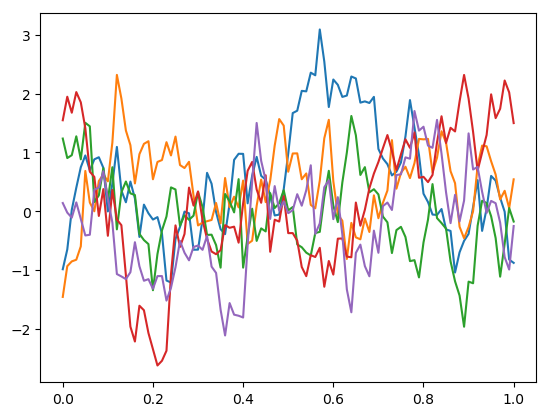

In [7]:
plot(grf,n=5)

## 2D Matérn covariance function

In this second example, we turn from Gaussian processes to Gaussian random fields ($d>1$). A well-known stationary isotropic covariance function is the Matérn covariance function

$$C(r) = \frac{2^{1-\nu}}{\Gamma(\nu)}\left(\sqrt{2\nu}\frac{r}{\lambda}\right)^\nu K_\nu\left(\sqrt{2\nu}\frac{r}{\lambda}\right)$$

where $\lambda$ is the correlation length and $\sigma$ is a smoothness parameter. Consider a Gaussian random field defined on $[0,1]^2$ that uses this covariance function.

In [8]:
mat = Matern(0.5,2.0)

Matérn (λ=0.5, ν=2.0, σ=1.0, p=2.0)

In [9]:
cov = CovarianceFunction(2,mat)

2d Matérn covariance function (λ=0.5, ν=2.0, σ=1.0, p=2.0)

We generate samples of this random field on a regular grid with $\Delta x = \Delta y = 2/100$ using circulant embedding. This is a fast and exact sampling method that uses an FFT.

In [11]:
pts = 0:0.02:1
grf = GaussianRandomField(cov,CirculantEmbedding(),pts,pts,minpadding=250)

Gaussian random field with 2d Matérn covariance function (λ=0.5, ν=2.0, σ=1.0, p=2.0) on a 51×51 structured grid, using a circulant embedding

Visualisation of this Gaussian random field is possible using `surf`, `contour` and `contourf`.

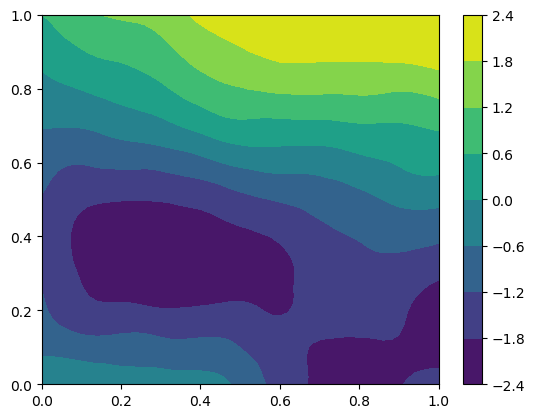

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe5889618d0>

In [13]:
contourf(grf)

Here is a visual comparison of different random fields with a decreasing smoothness parameter $\nu$.

In [15]:
pts = 0:0.02:1
grfs = GaussianRandomField[]
for ν in [2 1.5 1 0.5]
    mat = Matern(0.5,ν)
    cov = CovarianceFunction(2,mat)
    push!(grfs,GaussianRandomField(cov,CirculantEmbedding(),pts,pts,minpadding=250))
end

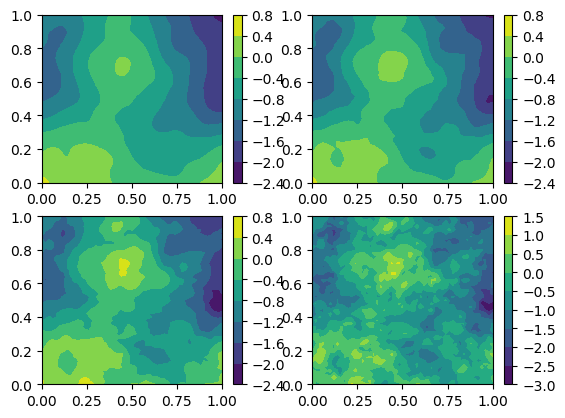

In [16]:
for i in 1:length(grfs)
    Random.seed!(0)
    subplot(2,2,i); contourf(grfs[i])
end

## 2D anisotropic random field

Suppose $Z(\boldsymbol{x},\omega)$ is a zero-mean Gaussian random field with stationary covariance function

$$ C(\boldsymbol{x},\boldsymbol{y}) = \exp\left(-(\boldsymbol{x}-\boldsymbol{y})^\intercal A (\boldsymbol{x}-\boldsymbol{y})\right) $$

where $A$ is a positive definte matrix. This covariance function is implemented as `AnisotropicExponential(A)`.

In [17]:
A = [1 0.8; 0.8 1]
an = AnisotropicExponential(A)
cov = CovarianceFunction(2,an)
pts = range(0; stop=10, length=256)

0.0:0.0392156862745098:10.0

We generate samples from this random field using a Karhunen-Loève (KL) expansion. This method expresses the random field as a linear combination of the eigenfunctions of the covariance operator, where the coefficients are standard normal random numbers.

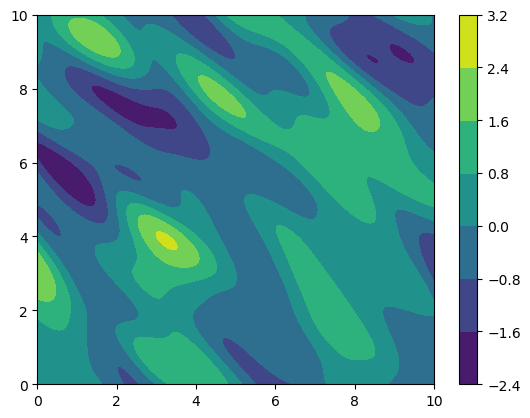

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe573bd35c0>

In [18]:
grf = GaussianRandomField(cov,KarhunenLoeve(500),pts,pts)
contourf(grf)

Below is a plot of the numerically approximated eigenvalues and eigenfunctions.

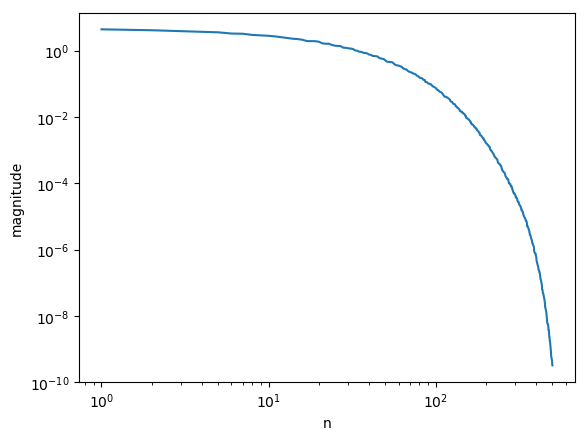

PyObject Text(24,0.5,'magnitude')

In [19]:
plot_eigenvalues(grf)

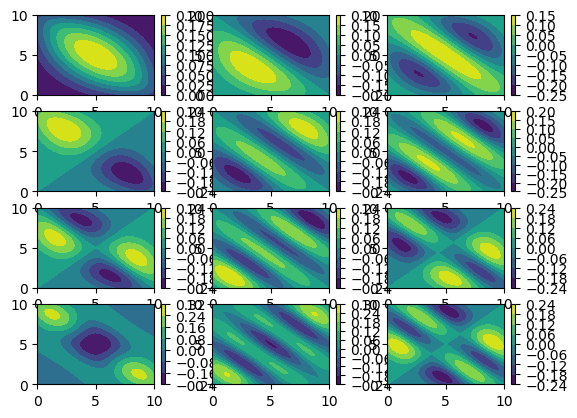

In [20]:
for i in 1:12
    subplot(4,3,i); plot_eigenfunction(grf,i)
end

## Gaussian random field generators

There is an implementation available for most common methods to generate Gaussian random fields: Cholesky factorization, Karhunen-Loève (KL) expansion, and circulant embedding. Which method is best suited for your application depends amongst others on the correlation length and smoothness of the covariance function, and the number of points in the domain of interest. In general, we recommend the circulant embedding technique or the KL expansion.

### Cholesky factorization

The `Cholesky()` method uses a Cholesky factorization of the covariance matrix. That is, we compute $C=LL'$, where $L$ is a lower triangular matrix. Samples of the Gaussian random field are computed as $Z=L\boldsymbol{\xi}$, where $\boldsymbol{\xi}$ is a vector of standard normal random numbers. As more and more points are used in the domain of interest, and especially in higher dimensions, computing the Choleksy factorization becomes too expensive. Furthermore, the expansion can only be computed when the covariance matrix is symmetric positive definite (SPD).

In [21]:
gau = Gaussian(0.1)
cov = CovarianceFunction(2,gau)
pts = 0:0.02:1
#grf = GaussianRandomField(cov,Cholesky(),pts,pts) # this will fail

0.0:0.02:1.0

If the covariance matrix is not positive definite, as in the above example, we can still compute an eigenvalue decomposition of the covariance matrix: $C=UDV'$. Samples are then provided using $Z= U\sqrt{D} \boldsymbol{\xi}$. If negative eigenvalues are detected, they will be ignored, and samples of the Gaussian random field will only be approximate. In that case, a warning will be printed.

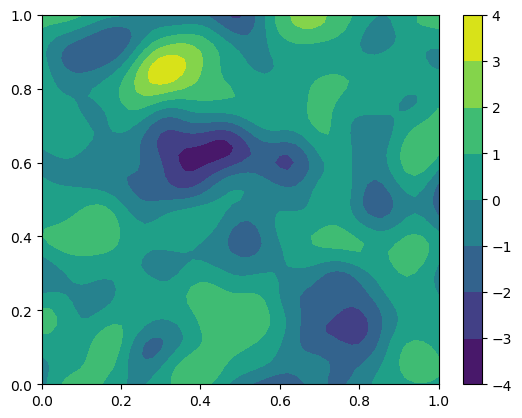

┌ Warning: 133 negative eigenvalues ≥ -2.965224959999663e-14 detected, Gaussian random field will be approximated (ignoring all negative eigenvalues)
└ @ GaussianRandomFields /home/david/.julia/dev/GaussianRandomFields/src/generators/spectral.jl:69


In [22]:
grf = GaussianRandomField(cov,Spectral(),pts,pts)
contourf(grf);

Since the largest negative eigenvalue has magnitude $\mathcal{O}(10^{-14})$ we can consider samples from this random field to have the exact desired covariance.

### Karhunen-Loève expansion

Suppose we are interested in a representation of a Gaussian process or Gaussian random field as an infinite series in terms of an orthonormal basis $\{\psi_n:n\in\mathbb{N}\}$ of $L^2(D)$. That is, we have

$$Z(\boldsymbol{x},\omega)-\bar{Z}(\boldsymbol{x}) = \sum_n^\infty \gamma_n(\omega) \psi_n(\boldsymbol{x}).$$

When the functions $\psi_n(\boldsymbol{x})$ are chosen as the eigenfunctions of the integral operator

$$ (\mathcal{C}f(\boldsymbol{y})) = \int_D C(\boldsymbol{x},\boldsymbol{y}) f(\boldsymbol{x}) \mathrm{d}\boldsymbol{x}$$

associated with the covariance function $C(\boldsymbol{x},\boldsymbol{y})$, the expansion is called the *Karhunen-Loève* expansion. In particular, a truncated KL expansion with $N$ terms can be written as 

$$Z(\boldsymbol{x},\omega)=\bar{Z}(\boldsymbol{x}) + \sum_n^N \sqrt{\theta_n} \psi_n(\boldsymbol{x})\xi_n(\omega),$$

where $\theta_n$ and $\psi_n$ are the eigenvalues and eigenvectors that result from a numerical approximation of the integral equation. Such an approximation can be obtained from a collocation method with suitable quadrature points. 

Here is an example for an exponential covariance function in two dimensions.

In [23]:
exp =  Exponential(0.1)
cov = CovarianceFunction(2,exp)
pts = 0:0.01:1
grf = GaussianRandomField(cov,KarhunenLoeve(250),pts,pts)

Gaussian random field with 2d exponential covariance function (λ=0.1, σ=1.0, p=2.0) on a 101×101 structured grid, using a KL expansion with 250 terms

The decay of the eigenvalues is shown below. Note that there is an *end effect* in the decay rate of the eigenvalues that results from the numerical approximation scheme. We show how this can be avoided in the next paragraph.

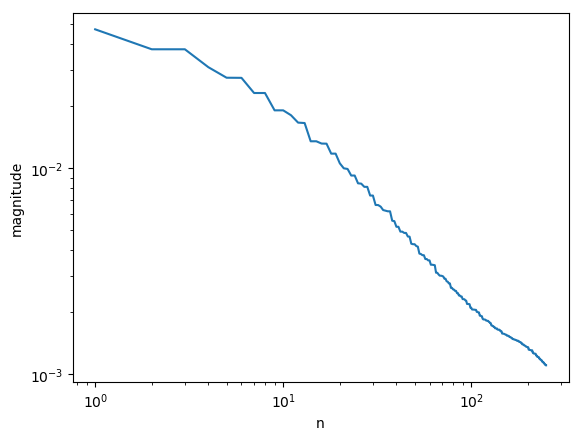

PyObject Text(24,0.5,'magnitude')

In [24]:
plot_eigenvalues(grf)

The first few eigenfunctions are shown below. Note that, as $n$ increases the eigenfunctions become more and more oscillatory.

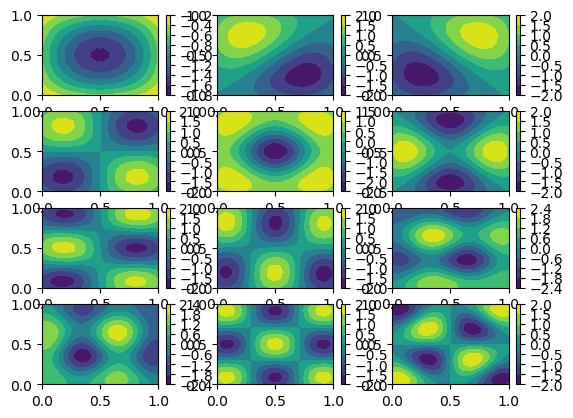

In [25]:
for i in 1:12
    subplot(4,3,i); plot_eigenfunction(grf,i)
end

There are several options to improve the numerical approximation of the KL expansion. The number of quadrature points (in one dimension) can be specified using the optional argument `nq`. The quadrature method can be `EOLE()` (default), `Midpoint()`, `Trapezoidal()`, `Simpson()` or `GaussLegendre()`.

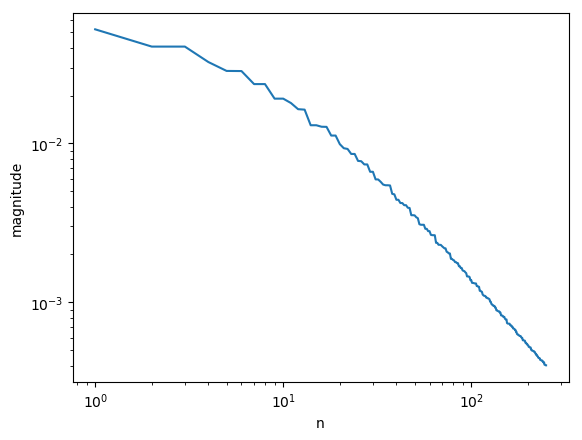

PyObject Text(24,0.5,'magnitude')

In [26]:
grf = GaussianRandomField(cov,KarhunenLoeve(250),pts,pts,nq=50,quad=GaussLegendre())
plot_eigenvalues(grf)

The more terms `n` are added in the expansion, the better the approximation using an `n`-term KL expansion will be. In fact, the KL expansion is the respresentation of a Gaussian random field that minimizes the *mean square error* for a finite number of terms `n`.

In [27]:
nterms = [1 2 5 10 20 50 100 200 500 1000]
error = similar(nterms, Float64)
for (i, n) in enumerate(nterms)
    grf = GaussianRandomField(cov,KarhunenLoeve(n),pts,pts)
    error[i] = rel_error(grf)
end

In [28]:
println(" #terms |  relative error")
println("--------------------------")
foreach(1:length(nterms)) do i
    @printf("   %4d |  %0.4f\n", nterms[i], error[i])
end

 #terms |  relative error
--------------------------
      1 |  0.7500
      2 |  0.5000
      5 |  0.4402
     10 |  0.3524
     20 |  0.1676
     50 |  0.1309
    100 |  0.0758
    200 |  0.0345
    500 |  0.0107
   1000 |  0.0032


### Circulant Embedding

Circulant embedding is an efficient technique to sample from isotropic and anisotropic stationary Gaussian random fields. When evaluated on a structured grid, the covariance matrix is known to have a nested block Toeplitz structure. By embedding this matrix into a larger circulant matrix, its eigenvalues can be computed rapidly using FFT.

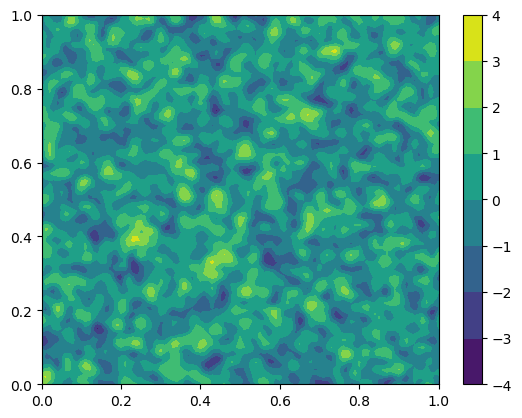

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe5882032e8>

In [29]:
an = AnisotropicExponential([2000 0; 0 2000])
cov = CovarianceFunction(2,an)
pts = 0:0.01:1
grf = GaussianRandomField(cov,CirculantEmbedding(),pts,pts)
contourf(grf)

Here is a plot of the numerically computed eigenvalues.

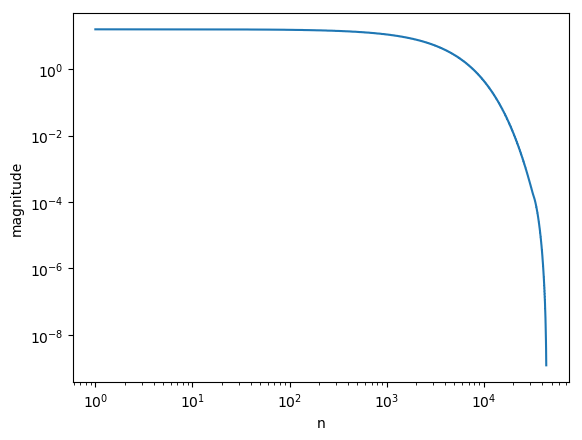

PyObject Text(24,0.5,'magnitude')

In [30]:
plot_eigenvalues(grf)

Although the computed samples are exact, and the method is efficient, it will only work if the points are defined on a regular equidistant grid. Interpolation can be necessary to obtain values in the points of interest.

In [28]:
#GaussianRandomField(cov,CirculantEmbedding(),collect(pts),collect(pts)) # this will terminate with an error

A small catch here is that, although the covariance matrix is positive semi-definite, its circulant extension in general is not. Hence, we must add some *ghost points* outside the domain of interest using the optional argument `padding`. If the matrix is not positive definite, an approximated Gaussian random field will still be computed using only the positive eigenvalues of the covariance matrix. Depending on the size of the smallest eigenvalue, this approximation may or may not be useable in practice.

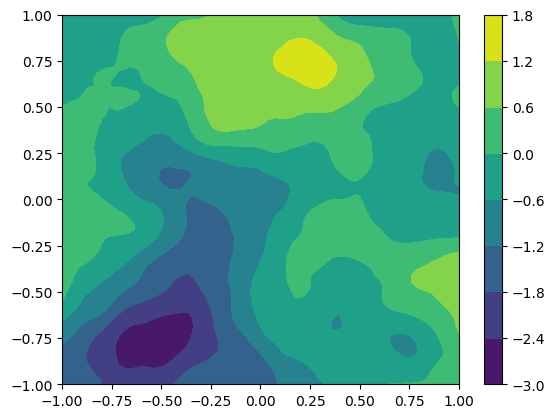

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe588997240>

In [33]:
mat = Matern(0.5,2)
cov = CovarianceFunction(2,mat)
pts = -1:0.02:1
grf = GaussianRandomField(cov,CirculantEmbedding(),pts,pts,minpadding=400)
contourf(grf)

For even greater efficiency, the optional flag `measure` will use `FFTW.MEASURE` to compute the best possible FFT algorithm for sampling from the Gaussian random field (default is `true`). A longer setup time is then relinguished for faster sampling. However, for very large matrices, this might potentially take lot of time, and it should be disabled.

## Other Gaussian random fields

Generation of non-isotropic Gaussian random fields is also possible by using the $p=1$ norm in the covariance function. This is a common thing to do if the random field represents for example the porosity of a rock. The standard deviation of the random field can be adapted with the optional argument $\sigma$. Here is an example of an exponential covariance function with constant mean $-1$, correlation length $\lambda=0.5$, norm $p=1$ and standard deviation $\sigma=0.5$.

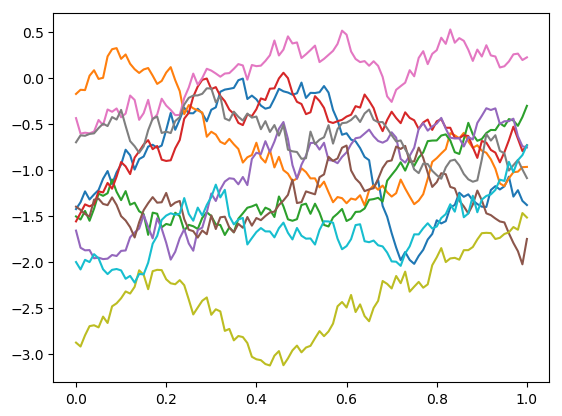

In [34]:
exp =  Exponential(0.5,σ=0.5,p=1)
cov = CovarianceFunction(1,exp)
pts = 0:0.01:1
grf = GaussianRandomField(-1,cov,CirculantEmbedding(),pts)
plot(grf,n=10)

It is also possible to define a Gaussian random field on a non-equidistant structured grid. Below is an example on a Chebyshev grid.

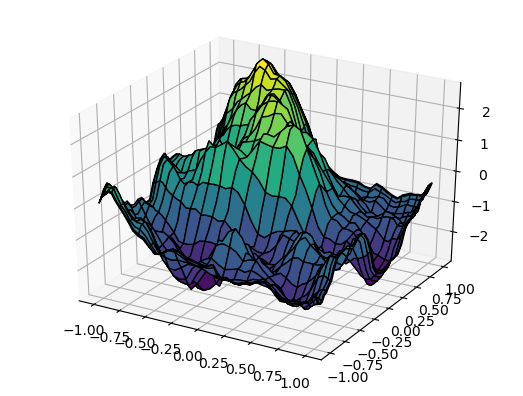

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fe582ffac50>

In [35]:
mat =  Matern(0.4,1.5)
cov = CovarianceFunction(2,mat)
pts = 0:0.02:1
pts = @. cos(pi*pts)
grf = GaussianRandomField(cov,Cholesky(),pts,pts)
surf(grf)

## Custom covariance functions

Another well-known covariance function is the triangular (or *tent*) covariance 

$C(r)=1-\frac{r}{\lambda}$, $r \in [0,\lambda]$.

For this kernel, analytic expressions are known for both eigenvalues and eigenfunctions. It is very straightforward to add this covariance function. We only need to define a `Triangular` type, and implement the `apply()` function. 

In [36]:
struct Triangular{T} <: IsotropicCovarianceStructure{T}
    λ::T
    σ::T
    p::T
end

GaussianRandomFields.apply(t::Triangular{T}, x::T) where T<:Real = 
    max(zero(T), 1 - x / t.λ)

GaussianRandomFields.shortname(::Triangular) = "Triangular"

Next, we can proceed as usual and compute a Gaussian random field that uses this tent covariance function with, for instance, a KL expansion.

In [37]:
t = Triangular(5.,1.,2.)
cov = CovarianceFunction(2,t)
grf = GaussianRandomField(cov,KarhunenLoeve(1000),0:0.01:1,0:0.01:1)

Gaussian random field with 2d Triangular covariance function (λ=5.0, σ=1.0, p=2.0) on a 101×101 structured grid, using a KL expansion with 1000 terms

A sample of this Gaussian random field looks like this:

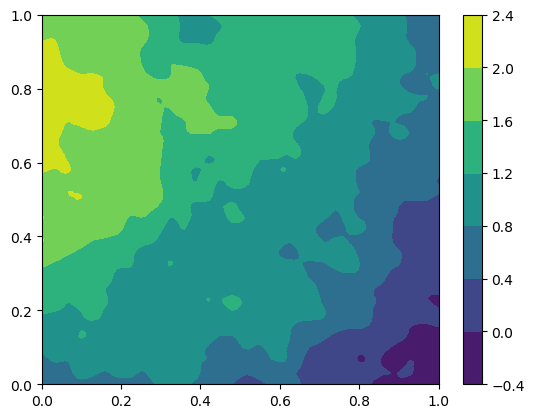

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe5832d0e10>

In [38]:
contourf(grf)

The numerically computed eigenvalues and eigenfunctions are shown below.

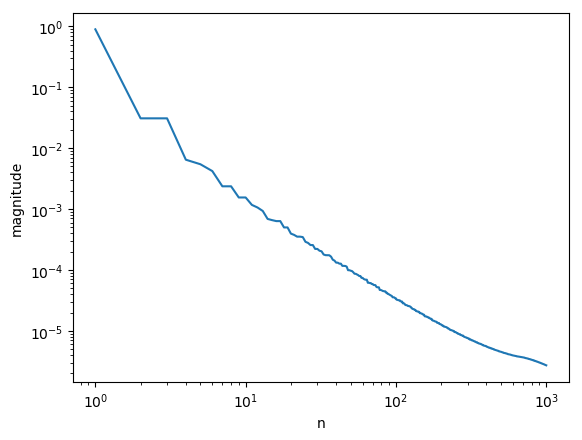

PyObject Text(24,0.5,'magnitude')

In [39]:
plot_eigenvalues(grf)

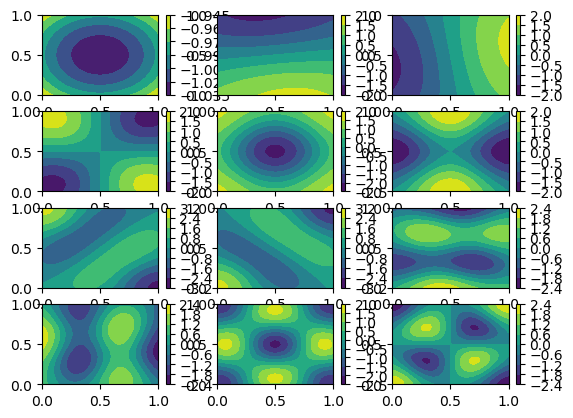

In [40]:
for i in 1:12
    subplot(4,3,i); plot_eigenfunction(grf,i)
end

## Gaussian random fields defined on a Finite Element mesh

Suppose the computational domain is not a square or rectangle, but is instead given as a Finite Element mesh. We can still compute a Gaussian random field in the points of this mesh. For example, a 7-pointed star has node table `p` and element table `t`.  

In [41]:
p, t = star();

In [42]:
mat = Matern(0.75,2.0)
cov = CovarianceFunction(2,mat)
grf = GaussianRandomField(cov,Cholesky(),p,t)

Gaussian random field with 2d Matérn covariance function (λ=0.75, ν=2.0, σ=1.0, p=2.0) on a mesh with 720 points and 1284 elements, using a Cholesky decomposition

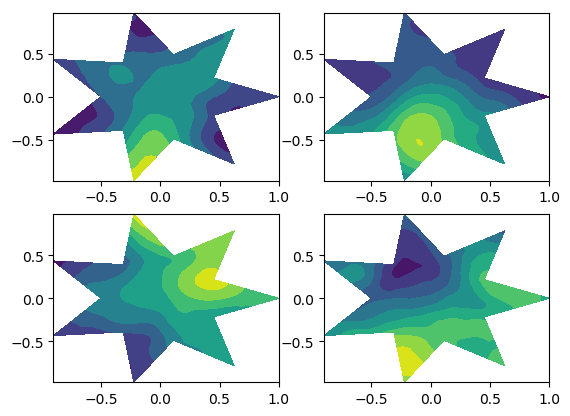

In [43]:
for i in 1:4
    subplot(2,2,i); tricontourf(grf,linewidth=0)
end

Alternatively, we can use a KL expansion where the collocation points are specified on a bounding box surrounding the FE mesh. 

In [44]:
grf = GaussianRandomField(cov,KarhunenLoeve(100),p,t)

Gaussian random field with 2d Matérn covariance function (λ=0.75, ν=2.0, σ=1.0, p=2.0) on a mesh with 720 points and 1284 elements, using a KL expansion with 100 terms

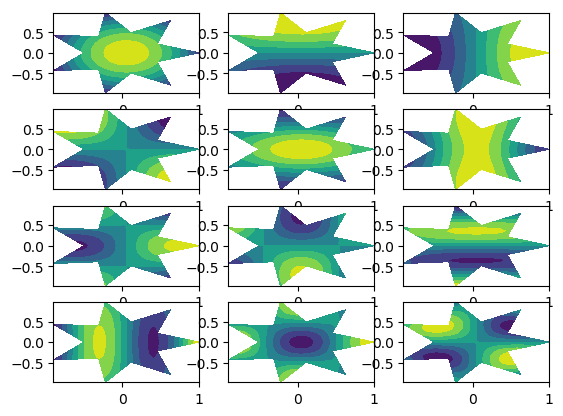

In [45]:
for i in 1:12
    subplot(4,3,i); plot_eigenfunction(grf,i,linewidth=0)
end

Note, however, that these eigenfunctions are computed on a bounding box that surrounds the finite element mesh. It is possible to compute the expansion using only the nodes on the mesh, via the truncated `Spectral` method.

In [46]:
p, t = Lshape()
grf = GaussianRandomField(CovarianceFunction(2,Matern(0.2,1.0)),Spectral(),p,t,n=6)

Gaussian random field with 2d Matérn covariance function (λ=0.2, ν=1.0, σ=1.0, p=2.0) on a mesh with 998 points and 1861 elements, using a spectral decomposition

Let's make a plot of the eigenfunctions over the L-shape.

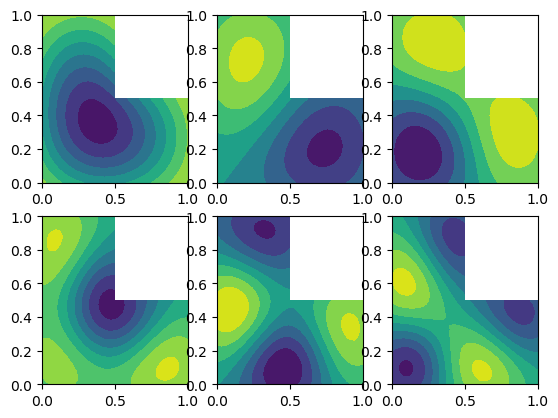

In [47]:
for n in 1:6
    subplot(2,3,n)
    tricontourf(p[:,1],p[:,2],grf.data.eigenfunc[:,n],triangles=t.-1,cmap=get_cmap("viridis"))
end

## 3D Gaussian random fields

Higher-dimensional random fiels are also implemented. For example, consider a three-dimensional Gaussian random field with Matérn covariance and $\lambda=0.1$, $\nu=2$.

In [48]:
mat = Matern(0.1,2.0)
cov = CovarianceFunction(3,mat)
pts = range(0; stop=1, length=64)
grf = GaussianRandomField(cov,CirculantEmbedding(),pts,pts,pts)

Gaussian random field with 3d Matérn covariance function (λ=0.1, ν=2.0, σ=1.0, p=2.0) on a 64×64×64 structured grid, using a circulant embedding

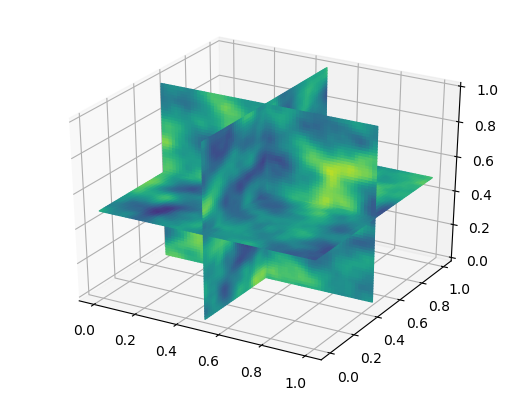

In [49]:
plot(grf)

For this computationally expensive covariance function, we could also use a separable covariance function, as in the next example.

## Separable non-stationary Gaussian random fields

Separable covariance functions $C(\boldsymbol{x},\boldsymbol{y})=C_1(\boldsymbol{x})C_2(\boldsymbol{y})$ have the property that their covariance matrix can be written as a tensor product of two vectors that only depend on $\boldsymbol{x}$ or $\boldsymbol{y}$ respectively. This can greatly reduce the computational cost of computing a Gaussian random field in many points. For example, to compute the KL expansion of a two-dimensional exponential covariance function with correlation length $\lambda=0.3$, we must compute the eigenvalue decomposition of two $m$-by-$m$ matrices (with $m$ the number of collocation points in each direction), instead of one $m^2$-by-$m^2$. This is more efficient both in memory and computation time.

In [50]:
exp = Exponential(0.3)
cov = SeparableCovarianceFunction(exp,exp)
grf = GaussianRandomField(cov,KarhunenLoeve(1000),0:0.01:1,0:0.01:1)

Gaussian random field with 2d separable covariance function [ exponential (λ=0.3, σ=1.0, p=2.0), exponential (λ=0.3, σ=1.0, p=2.0) ] on a 101×101 structured grid, using a KL expansion with 1000 terms

However, the visual artefacts of the tensor product are now clearly apparent in each sample.

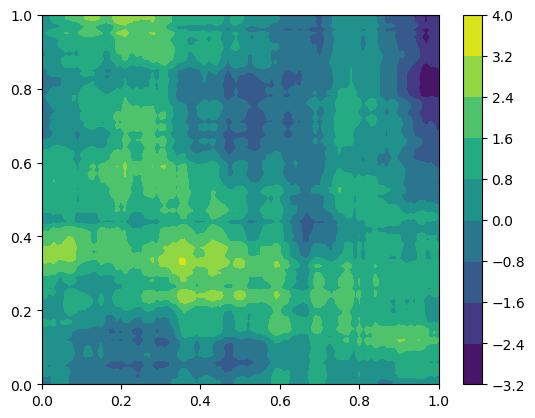

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe58258a5f8>

In [51]:
contourf(grf)